# Week 2 - Ungraded Lab: A Journey through Data

The paradigm behind machine learning is shifting from model-centric to data-centric. In this lab, you will see how data preparation affects the output of your models. You will build an image classifier that detects three classes: dog, cat, and bird. To demonstrate the effect of your input data, you will only use a single model throughout -- a simple Convolutional Neural Network (CNN) -- and will only vary the dataset. You will navigate common problems such as class imbalance and overfitting, and will walk through useful diagnosis tools and methods to mitigate these issues.

We have provided pretrained models for this lab to help you focus on observation and reflection about data-centric AI. However, if you are interested in training the models yourself, we have included optional instructions to do so. **If you're interested in training the models yourself,** please read the notes below.

<details>
  <summary><font size="3" color="blue"><b>Click here for important notes regarding training the models in this lab</b></font></summary>

&nbsp;

**NOTE 1:**
There are a total of 3 CNNs that require training and although some parameters have been tuned to provide a faster training time, this may result in a long time spent running this lab rather than thinking about what you observe.

To speed things up, we have provided pre-trained versions of each model along with their respective training history. We recommend you use these pre-trained versions to save time. If you choose this option, you can stay here in the Coursera Lab environment to run the entire lab.

**However, if you want to perform the model training yourself, the code for replicating the training is provided as well. In this case, a GPU is absolutely necessary. The Coursera Lab environment only runs on CPU so you need to use another environment such as Colab to train the models.**

You can open this lab on Colab by clicking on the badge below:

<a href="https://colab.research.google.com/github/https-deeplearning-ai/machine-learning-engineering-for-production-public/blob/version_3/course1/week2-ungraded-lab/C1W2_Ungraded_Lab_Birds_Cats_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To make sure your runtime is GPU, you can select `Runtime -> Change runtime type -> T4 GPU` from the menu and wait for the runtime to reconnect (if it's not already selected).


**NOTE 2:**

Colab **does not** guarantee access to a GPU. This depends on the availability of these resources. However **it is not very common to be denied GPU access**. If this happens to you, remember that you can still run this lab without training the models yourself. If you really want to do the training but are denied a GPU, try switching the runtime to a GPU after a couple of hours.

To know more about Colab's policies check out this [FAQ](https://research.google.com/colaboratory/faq.html).


</details>

## Lab Setup

Start by downloading the dataset. You will be using a combination of the [Cats vs. Dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) and [Caltech Birds](https://www.vision.caltech.edu/datasets/cub_200_2011/) datasets.

In [1]:
# Download the dataset
!wget -nc https://storage.googleapis.com/mlep-public/course_1/week2/cats_dogs_birds.tar.gz

File ‘cats_dogs_birds.tar.gz’ already there; not retrieving.



You will also download a `lab_utils.py` file. This file contains helper functions for this lab. Feel free to explore this file if you want to see how they are implemented.

In [2]:
# Download lab utilities
!wget -nc https://storage.googleapis.com/mlep-public/course_1/week2/lab_utils.py

File ‘lab_utils.py’ already there; not retrieving.



Next, you will also need to download the pre-trained models and histories below. These will allow you to see sample results without training the models yourself. (If you intend to train the models yourself in an environment with a GPU, you can skip this step.)

In [3]:
# Download pretrained models and training histories
!wget -q -nc -P ./models/ https://storage.googleapis.com/mlep-public/course_1/week2/v2/imbalanced_model.tar.gz
!wget -q -nc -P ./models/ https://storage.googleapis.com/mlep-public/course_1/week2/v2/balanced_model.tar.gz
!wget -q -nc -P ./models/ https://storage.googleapis.com/mlep-public/course_1/week2/v2/augmented_model.tar.gz
!wget -q -nc -P ./histories/ https://storage.googleapis.com/mlep-public/course_1/week2/v2/imbalanced_history.pkl
!wget -q -nc -P ./histories/ https://storage.googleapis.com/mlep-public/course_1/week2/v2/balanced_history.pkl
!wget -q -nc -P ./histories/ https://storage.googleapis.com/mlep-public/course_1/week2/v2/augmented_history.pkl

You will now import the packages needed in this lab.

In [5]:
import os
import gc
import tarfile
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
import lab_utils
import tensorflow as tf
from IPython.display import Image, display

You will also define some global variables that you will use throughout the lab.

In [6]:
# Filename of the downloaded dataset archive
DATASET_COMPRESSED = './cats_dogs_birds.tar.gz'

# Base directory for extracting and preparing the dataset
DATA_DIR = '/tmp/data'

# Base directory for extracting the pretrained models
MODEL_DIR = './models'

# Name of the classes to predict
ANIMALS = ['dogs', 'cats', 'birds']

# Directories for the training and dev sets
TRAIN_DIRS = ['train/dogs', 'train/cats', 'train/birds']
DEV_DIRS = ['dev/dogs', 'dev/cats', 'dev/birds']

# Imbalanced portion of images among the 3 classes
PORTIONS = [0.2, 1, 0.1]

Next, run the cell below to extract the pretrained models. If you intend to train the models yourself in an environment with a GPU, you can skip this step. (Note: If you're running this on Coursera, the models are already pre-extracted on your environment so you can skip this step).

In [ ]:
# # Extract the compressed models (Not needed in the Coursera environment)
# compressed_models = ['imbalanced_model.tar.gz', 'balanced_model.tar.gz', 'augmented_model.tar.gz']

# for compressed_model in compressed_models:
#     with tarfile.open(f'{MODEL_DIR}/{compressed_model}', 'r') as my_tar:
#       my_tar.extractall(MODEL_DIR)

## A story of data

Throughout this lab, you will simulate a real life scenario:

You have been tasked with creating a model that classifies images of cats, dogs and birds. To establish a baseline, you settle on a simple Convolutional Neural Network (CNN) architecture since CNNs are known to perform well on image classification tasks. You thought of using two widely used datasets: `cats vs dogs`, and `caltech birds` to train your model. 

_Note: Both datasets are also available through [TensforFlow Datasets (TFDS)](https://github.com/tensorflow/datasets). For this lab however, you will prepare the datasets yourself so that you have more control over the manipulations._

You downloaded the compressed dataset earlier and the next step is extracting it to a base directory. This usually takes a few seconds, but sometimes up to a minute.

In [7]:
# Extract the dataset
with tarfile.open(DATASET_COMPRESSED, 'r') as my_tar:
  my_tar.extractall(DATA_DIR)

The dataset has an `images` top-level directory and has 3 subdirectories for each class: `dog`, `cat`, and `bird`.

In [8]:
os.listdir(DATA_DIR)

['images']

In [9]:
os.listdir(f'{DATA_DIR}/images')

['cat', 'bird', 'dog']

You will assign these to variables and check how many images are in each subdirectory.

In [10]:
base_dogs_dir = os.path.join(DATA_DIR, 'images/dog')
base_cats_dir = os.path.join(DATA_DIR,'images/cat')
base_birds_dir = os.path.join(DATA_DIR,'images/bird')
base_image_dirs = [base_dogs_dir, base_cats_dir, base_birds_dir]

for animal, base_image_dir in zip(ANIMALS, base_image_dirs):
    print(f"There are {len(os.listdir(base_image_dir))} images of {animal}")

There are 11685 images of dogs
There are 11754 images of cats
There are 11788 images of birds


It turns out that there is a similar number of images for each class you are trying to predict. This will likely lead to your model having the same performance on all three classes.

Take a quick look at an image from each class.

Sample cat image:


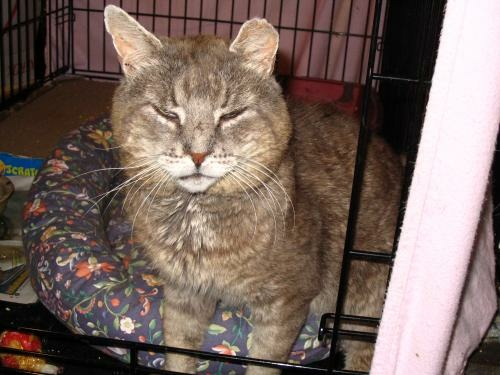


Sample dog image:


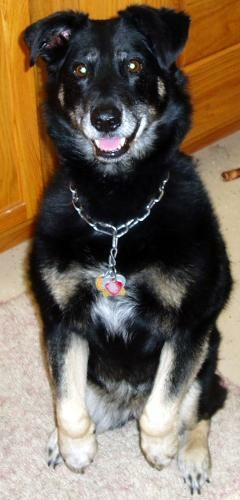


Sample bird image:


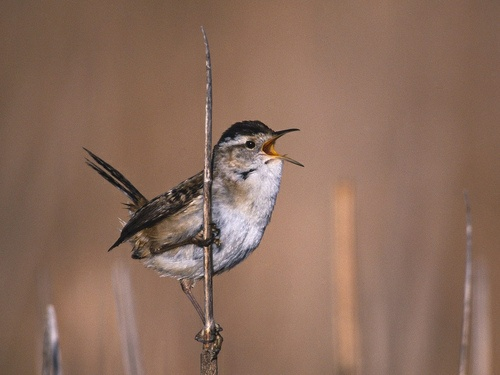

In [11]:
print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

## Train / Dev Split

Before training the model, you need to split the data into training and dev sets. For training, you will use the [`Keras`](https://keras.io) application programming interface (API) which includes functionality to read images from  various directories.

Run the next cell to create the directories for training and dev sets.

In [12]:
for dir in TRAIN_DIRS:
    os.makedirs(os.path.join(DATA_DIR, dir), exist_ok=True)
    
for dir in DEV_DIRS:
    os.makedirs(os.path.join(DATA_DIR, dir), exist_ok=True)

Notice that there are now `train` and `dev` directories in the base data directory.

In [13]:
os.listdir(DATA_DIR)

['train', 'dev', 'images']

Moreover, these have subdirectories for each class.

In [14]:
os.listdir(os.path.join(DATA_DIR, 'train'))

['birds', 'cats', 'dogs']

In [15]:
os.listdir(os.path.join(DATA_DIR, 'dev'))

['dogs', 'cats', 'birds']

You will move a percentage of images from an origin folder to a destination folder as desired to generate the training and dev splits. You will use the `move_to_destination()` function from `lab_utils` for this step.

In [16]:
# Move 70% of the images to the training directories
for base_image_dir, train_dir in zip(base_image_dirs, TRAIN_DIRS):
    lab_utils.move_to_destination(
        base_image_dir, 
        os.path.join(DATA_DIR, train_dir), 
        0.7
    )


# Move the remaining images to the eval directories
for base_image_dir, dev_dir in zip(base_image_dirs, DEV_DIRS):
    lab_utils.move_to_destination(
        base_image_dir, 
        os.path.join(DATA_DIR, dev_dir), 
        1
    )

Check how many images you have available for each split and class:

In [17]:
for animal, train_dir in zip(ANIMALS, TRAIN_DIRS):
    print(f"There are {len(os.listdir(os.path.join(DATA_DIR, train_dir)))} images of {animal} for training")

print()

for animal, dev_dir in zip(ANIMALS, DEV_DIRS):
    print(f"There are {len(os.listdir(os.path.join(DATA_DIR, dev_dir)))} images of {animal} for evaluation")

There are 8179 images of dogs for training
There are 8227 images of cats for training
There are 8251 images of birds for training

There are 3506 images of dogs for evaluation
There are 3527 images of cats for evaluation
There are 3537 images of birds for evaluation


## An unexpected issue!

Let's face the first real life issue in this narrative! There was a power outage in your office and some hard drives were damaged. As a result of the damage, many of the images for `dogs` and `birds` have been erased. As a matter of fact, only 20% of the dog images and 10% of the bird images survived.

To simulate this scenario, create a new directory called `imbalanced` and copy only the portions mentioned above for each class.

In [18]:
for dir in TRAIN_DIRS + DEV_DIRS:
    os.makedirs(os.path.join(DATA_DIR, 'imbalanced/'+dir), exist_ok=True)

In [19]:
# Perform the copying
for train_dir, portion in zip(TRAIN_DIRS, PORTIONS):
    lab_utils.copy_with_limit(
        os.path.join(DATA_DIR, train_dir), 
        os.path.join(DATA_DIR, f'imbalanced/{train_dir}'), 
        portion
    )

for dev_dir, portion in zip(DEV_DIRS, PORTIONS):
    lab_utils.copy_with_limit(
        os.path.join(DATA_DIR, dev_dir), 
        os.path.join(DATA_DIR, f'imbalanced/{dev_dir}'), 
        portion
    )

Now, check the images for each split and class again. You'll notice that the images are now imbalanced, where the cat pictures dominate the dataset.

In [20]:
# Print number of available images
for animal, train_dir in zip(ANIMALS, TRAIN_DIRS):
    print(f"There are {len(os.listdir(os.path.join(DATA_DIR, f'imbalanced/{train_dir}')))} images of {animal} for training")

print()

for animal, dev_dir in zip(ANIMALS, DEV_DIRS):
    print(f"There are {len(os.listdir(os.path.join(DATA_DIR, f'imbalanced/{dev_dir}')))} images of {animal} for evaluation")

There are 1635 images of dogs for training
There are 8227 images of cats for training
There are 825 images of birds for training

There are 701 images of dogs for evaluation
There are 3527 images of cats for evaluation
There are 353 images of birds for evaluation


For now there is no quick or clear solution to remedy the accidental file loss. You decide to keep going and train the model with the remaining images.

## Selecting the model

Use the `lab_utils.create_model()` function to create a model and define a loss function, optimizer and performance metrics leveraging the Keras API. You can print out the model summary as a quick check.

In [21]:
# Create a model to use with the imbalanced dataset
imbalanced_model = lab_utils.create_model()

# Print the model's summary
print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

## Preparing the Data

You will use the [tf.data API](https://www.tensorflow.org/guide/data) to prepare the datasets so it can be consumed by the model.

The [image_dataset_from_directory() utility](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) allows reading images from a base directory and outputs a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). You will pass in the following arguments:

- `directory`: Path to the root directory where the images are stored. In this case, you'll be pulling from the `imbalanced` train and dev directories.
- `image_size`: The dimensions to which all images found will be resized. Since images come in all kinds of resolutions, you need to standardize their size. 150x150 is used here, but other values should work well too.
- `batch_size`: Number of images the generator yields every time it is asked for a next batch. 32 is used here.
- `label_mode`: How the labels are represented. Here `int` is used to indicate that labels will be 1D. This is done for compatibility with the loss and evaluation metrics used when compiling the model.

In [22]:
# Instantiate the Dataset object for the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,'imbalanced/train'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
    )

# Instantiate the Dataset object for the dev set
dev_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,'imbalanced/dev'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
    )

Found 10687 files belonging to 3 classes.
Found 4581 files belonging to 3 classes.


Images are usually normalized to help with the model learning. You will use the [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) preprocessing layer to transform the raw image pixels into the range `[0,1]`.

In [23]:
# Define the layer to normalize the images
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Apply the layer to the datasets
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
dev_dataset_scaled = dev_dataset.map(lambda image, label: (rescale_layer(image), label))

You will chain in a few more methods to the datasets. In addition to shuffling the training set, using the [cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) will help speed up the training. You can read more about it [here](https://www.tensorflow.org/guide/data_performance#caching) and [here](https://www.tensorflow.org/guide/data_performance#prefetching).

In [24]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      )

dev_dataset_final = (dev_dataset_scaled
                            .cache()
                            .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                           )

##  Training a CNN with class imbalanced data

Now you're ready to train the model. If you're using the recommended pretrained models, move to the next step to analyze the model performance. (If you intend to train the models yourself in an environment with a GPU, run the code cell below.)

In [ ]:
# # Run only if you want to train the model yourself. This takes around 3 mins with GPU enabled on Colab.

# # Create a model to use with the imbalanced dataset
# imbalanced_model = lab_utils.create_model()

# imbalanced_history = imbalanced_model.fit(
#     train_dataset_final,
#     epochs=10,
#     validation_data=dev_dataset_final
#     )

To analyze the model performance properly, it is important to track different metrics such as accuracy and loss during the training process. Plot the metrics and losses for each training epoch using the `lab_utils.plot_train_eval()` helper function. If you opted not to do the training yourself, the code below will load pre-generated files from one of our training sessions.

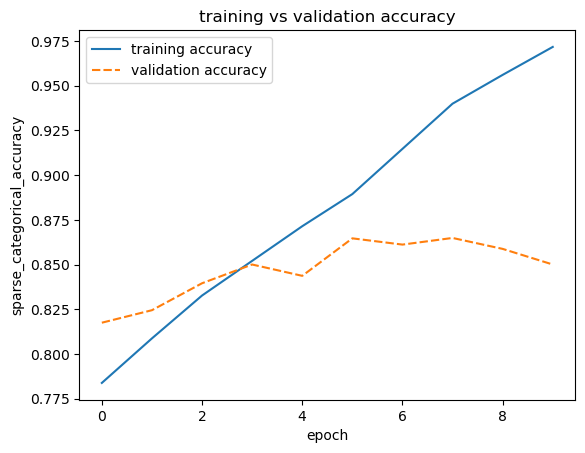

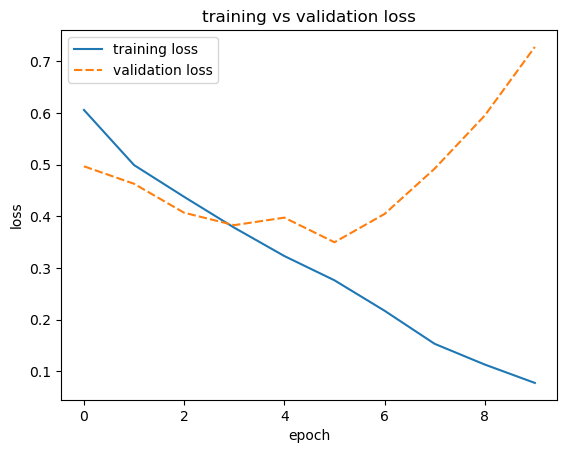

In [25]:
# This will succeed if the model was trained on Colab or an environment with GPU.
try:
    lab_utils.plot_train_eval(imbalanced_history)

# If it fails, load pre-generated history and model files.
except NameError:

    # Load the history
    with open('./histories/imbalanced_history.pkl', "rb") as pickle_file:
        imbalanced_history = pickle.load(pickle_file)

    # Load the pre-trained imbalanced model. This will be used in the next cell.
    imbalanced_model = tf.keras.models.load_model('./models/imbalanced_model')

    # Plot the train and dev accuracy and loss
    lab_utils.plot_train_eval(imbalanced_history)

From these two plots, it's evident that the model is overfitting the training data. However, the validation accuracy is still pretty high. Maybe class imbalance is not such a big issue after all. Perhaps this is too good to be true.

Let's dive a little deeper, and compute some additional metrics to explore if the class imbalance is hampering the model to perform well. In particular, let's compare: the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html),  the [balanced accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html), and the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).  Information on the accuracy scores calculations is provided in the [sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) documentation. You can also review the confusion matrix [here](https://en.wikipedia.org/wiki/Confusion_matrix).

In [26]:
# Get the true labels from the dev set
y_true = dev_dataset_final.map(lambda image, label: label).unbatch()
y_true = list(y_true)

# Use the model to predict. This will take about a minute
predictions_imbalanced = imbalanced_model.predict(dev_dataset_final)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

144/144 [==============================] - 41s 278ms/step
Accuracy Score: 0.8500327439423707
Balanced Accuracy Score: 0.6883181183037097


Comparing the `accuracy` and `balanced accuracy` metrics, the class imbalance starts to become apparent. Now, compute the `confusion matrix` of the predictions. Notice that the class imbalance is also present in the dev set, so the confusion matrix will show an overwhelming majority of predictions for cats.

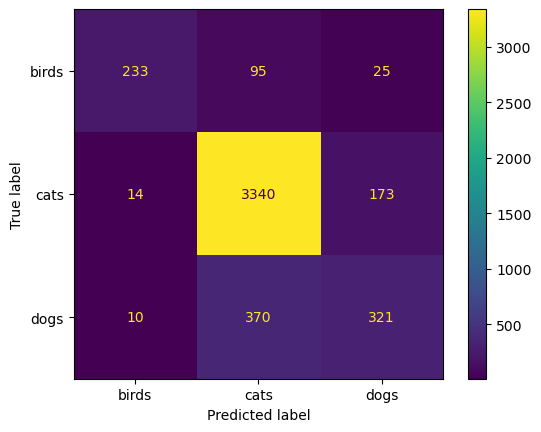

In [27]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)

ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

If you show the misclassified images per class, you'll notice that the model expectedly does well for cats but not so much for birds and dogs.

In [28]:
misclassified_birds = (imbalanced_cm[0, 1] + imbalanced_cm[0, 2])/np.sum(imbalanced_cm, axis=1)[0]
misclassified_cats = (imbalanced_cm[1, 0] + imbalanced_cm[1, 2])/np.sum(imbalanced_cm, axis=1)[1]
misclassified_dogs = (imbalanced_cm[2, 0] + imbalanced_cm[2, 1])/np.sum(imbalanced_cm, axis=1)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 33.99%
Proportion of misclassified cats: 5.30%
Proportion of misclassified dogs: 54.21%


Class imbalance is a real problem. If it's not detected early on, it can give the wrong impression that your model is performing better than it actually is. For this reason, it is important to rely on several metrics that do a better job at capturing these kinds of issues. **In this case, the overall `accuracy` metric is misleading** because the good results for the dominant class (i.e. cats) hide the poor results in the other two.

To prove this point further, consider a model that only predicts cats:

In [29]:
# Predict cat for all images
all_cats = np.ones(len(y_true))

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.769919231608819
Balanced Accuracy Score: 0.3333333333333333


If you only look at the `accuracy` metric, the model seems to be working fairly well, since the majority class is the same that the model always predicts.

To address class imbalance, you can simply gather more data or use other techniques. For instance, [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) oversamples the minority classes by creating synthetic data. However, these techniques are outside the scope of this lab.

Before moving forward, you can free up some memory by running the next cell.


In [30]:
# Delete unused variables
del train_dataset
del dev_dataset
del train_dataset_scaled
del dev_dataset_scaled
del train_dataset_final
del dev_dataset_final
del imbalanced_history
del imbalanced_model
del y_true
del predictions_imbalanced
del y_pred_imbalanced
del all_cats

# Call the Python garbage collector to free memory
gc.collect()

35574

# Training with the complete dataset

For the time being and following the narrative, assume that a colleague of yours was careful enough to save a backup of the complete dataset in her cloud storage. Now you can try training without the class imbalance issue. What a relief!

You will now train the model with the balanced dataset.

In [31]:
# Instantiate the Dataset object for the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,'train'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
    )

# Instantiate the Dataset object for the dev set
dev_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,'dev'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
    )

# Define the layer to normalize the images
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Apply the layer to the datasets
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
dev_dataset_scaled = dev_dataset.map(lambda image, label: (rescale_layer(image), label))

train_dataset_final = train_dataset_scaled.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_dataset_final = dev_dataset_scaled.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 24657 files belonging to 3 classes.
Found 10570 files belonging to 3 classes.


<details>
  <summary><font size="3" color="blue"><b>Click here if you are training the model yourself and the Colab runtime crashed</b></font></summary>

&nbsp;

The Colab RAM may not be sufficient to run all the exercises here in one go. If the runtime crashes while training, you can recover by:

* Going to the top of this lab
* Run the cells in the `Lab Setup` section,  particularly the imports and global variable definitions.
* **There is no need to run the cells in the `Preparing the Data` and `Training a CNN with class imbalanced data` sections.
* Scroll back to this section (i.e. `Training with the complete dataset`) and run the cells again to start training.

</details>

In [32]:
# # Run only if you want to train the model yourself. This takes around 5 minutes on Colab.

# # Create a model to use with the balanced dataset
# balanced_model = lab_utils.create_model()

# balanced_history = balanced_model.fit(
#     train_dataset_final,
#     epochs=10,
#     validation_data=dev_dataset_final)

In [33]:
# This will succeed if the model was trained on Colab or an environment with GPU.
try:
    balanced_history

# If it fails, load pre-generated history and model files.
except NameError:

    # Load the history
    with open('./histories/balanced_history.pkl', "rb") as pickle_file:
        balanced_history = pickle.load(pickle_file)

    # Load the pre-trained imbalanced model. This will be used in the next cell.
    balanced_model = tf.keras.models.load_model('./models/balanced_model')

Let's check how the `accuracy` vs `balanced accuracy` comparison looks like now:

<details>
  <summary><font size="3" color="blue"><b>Click here if the cell below restarts the kernel</b></font></summary>

&nbsp;

Sometimes, freeing the RAM gets delayed so running the cell below might crash after the previous exercises. If that happens, you can recover by:

* Going to the top of this lab
* Run the cells in the `Lab Setup` section,  particularly the imports and global variable definitions.
* **There is no need to run the cells in the `Preparing the Data` and `Training a CNN with class imbalanced data` sections.
* Scroll back to this section (i.e. `Training with the complete dataset`) and run the cells again to start the model evaluation.

</details>

In [35]:
# Get the true labels
y_true = dev_dataset_final.map(lambda image, label: label).unbatch()
y_true = list(y_true)

# Use the model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(dev_dataset_final)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

331/331 [==============================] - 88s 258ms/step
Accuracy Score: 0.8635761589403973
Balanced Accuracy Score: 0.8634934106297684


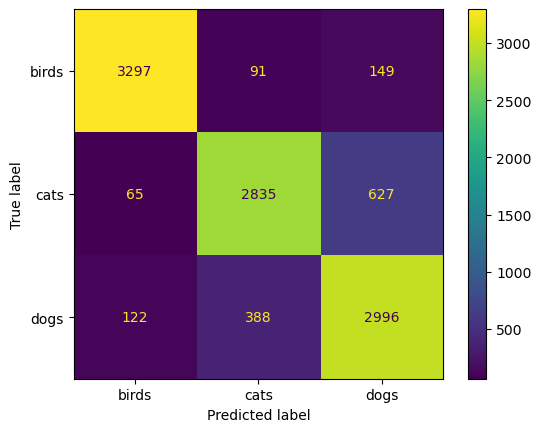

In [36]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

Both accuracy-based metrics are very similar now. The confusion matrix also looks way better than before. This result suggests that class imbalance has been successfully mitigated by adding more data to the previously undersampled classes.

Now that you know that you can trust the `accuracy` metric, plot the training history:

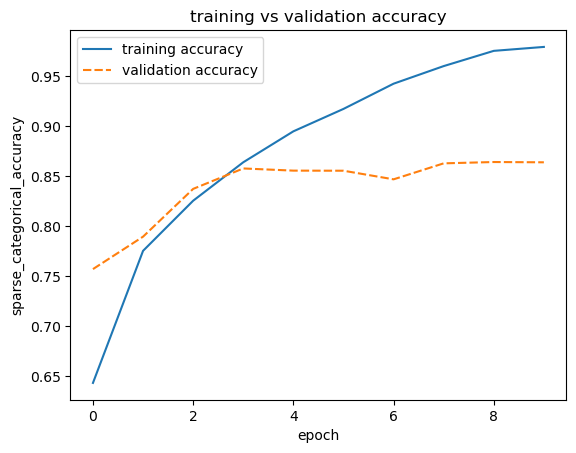

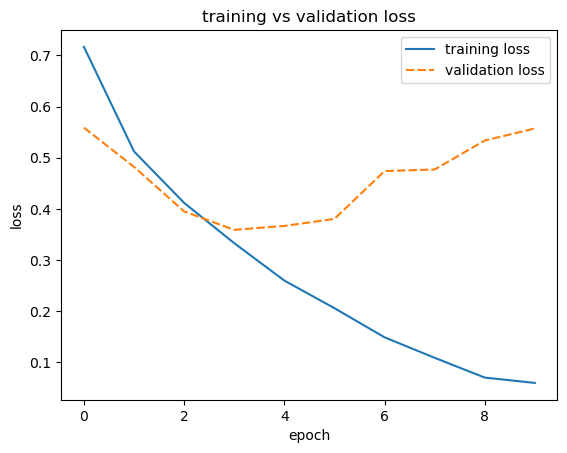

In [37]:
lab_utils.plot_train_eval(balanced_history)

This looks better than the earlier graphs for the imbalanced case. However, overfitting is still present.

Can you think of ways to address this issue? If you are familiar with CNNs, you might think of adding [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers. This intuition is correct, but for now, you decide to stick with the same model and only change the data to see if it is possible to mitigate overfitting this way.

Keeping the model constant, one other possible solution to address overfitting is to apply data augmentation. Your whole team agrees this is the way to go so you decide to try this next.

Before moving forward, you can free up some memory by running the next cell.

In [38]:
# Delete unused variables
del train_dataset
del dev_dataset
del train_dataset_scaled
del dev_dataset_scaled
del train_dataset_final
del dev_dataset_final
del balanced_history
del balanced_model
del y_true
del predictions_balanced
del y_pred_balanced

# Call the Python garbage collector to free memory
gc.collect()

31053

# Training with Data Augmentation

Augmenting images is a technique where you create new versions of existing images in the dataset by applying geometric transformations. These transformations can vary from zooming in and out, rotating, or even flipping the images. By performing these transformations, you get a training dataset that exposes the model to a wider variety of images. This technique helps to further explore the feature space and hence reduce the chance of overfitting.

It is also a very natural idea since doing slight (or sometimes not so slight) changes to an image will result in an equally valid image. A cat sitting in an awkward position is still a cat, right?

You can do data augmentation in Keras by using [image augmentation layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/). These are only active during training and will automatically be bypassed during model prediction. The cell below creates a data augmentation model that flips, rotates, translates, and zooms the images randomly.

In [39]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([

        # Specify the input shape on the first layer.
        tf.keras.layers.RandomFlip("horizontal", input_shape=(150,150,3)),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)

        ]
)

You can pass in some images to the `lab_utils.demo_augmentation()` function and see how they are transformed by these layers. First, get a sample batch from the training dataset and put the images in a list.

In [40]:
# Instantiate the Dataset object for the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,'train'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
    )

# Instantiate the Dataset object for the dev set
dev_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,'dev'),
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
    )

# Define the layer to normalize the images
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Apply the layer to the datasets
train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
dev_dataset_scaled = dev_dataset.map(lambda image, label: (rescale_layer(image), label))

train_dataset_final = train_dataset_scaled.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_dataset_final = dev_dataset_scaled.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 24657 files belonging to 3 classes.
Found 10570 files belonging to 3 classes.


In [41]:
# Get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


Then pass some images from this list to the utility function. The cell below modifies the original images four times and previews the results.

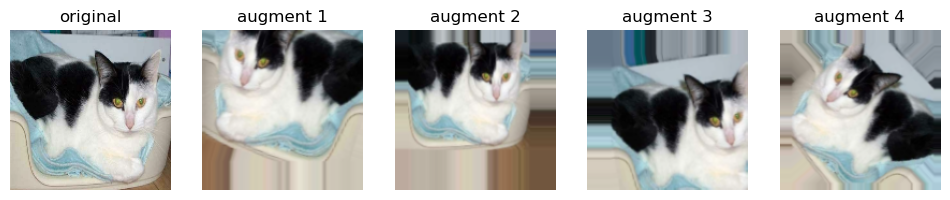

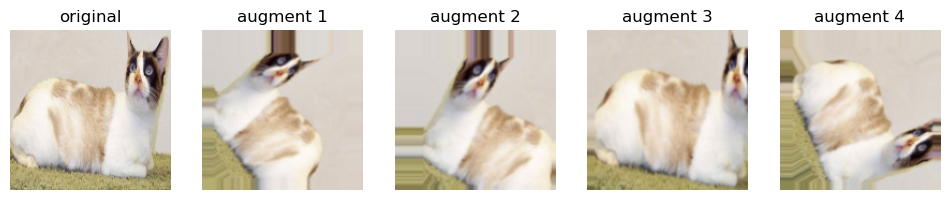

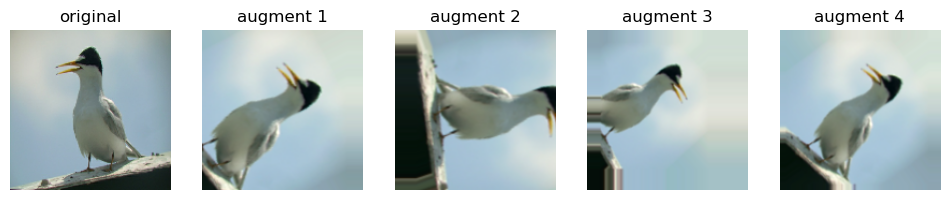

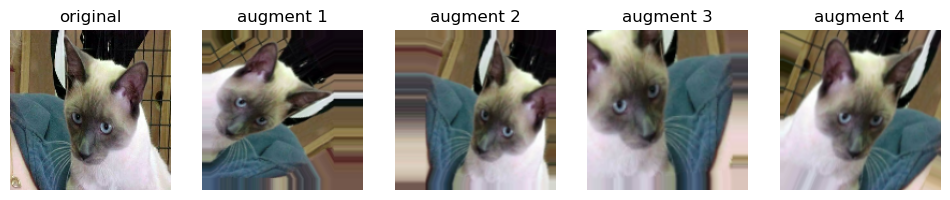

In [42]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
lab_utils.demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
lab_utils.demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
lab_utils.demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
lab_utils.demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

Feel free to modify the parameters in the data augmentation model and see how it transforms the original images. Now that you know what it is doing to the training images, you can move onto training. You will prepend the data augmentation model to the base model as shown below.

In [43]:
# Instantiate the base model
base_model = lab_utils.create_model()

# Prepend the data augmentation layers to the base model
augmented_model = tf.keras.models.Sequential([
    data_augmentation,
    base_model
])

# Compile the model
augmented_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

<details>
  <summary><font size="3" color="blue"><b>Click here if you are training the model yourself and the Colab runtime crashed</b></font></summary>

&nbsp;

The Colab RAM may not be sufficient to run all the exercises here in one go. If the runtime crashes while training, you can recover by:

* Going to the top of this lab
* Run the cells in the `Lab Setup` section,  particularly the imports and global variable definitions.
* **There is no need to run the cells in the `Preparing the Data`, `Training a CNN with class imbalanced data`, and `Training with a complete dataset` sections.**
* Scroll back to this section (i.e. `Training with Data Augmentation`) and run the cells again to start training.

</details>

In [44]:
# # Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# augmented_history = augmented_model.fit(
#     train_dataset_final,
#     epochs=40,
#     validation_data=dev_dataset_final)

Since you know that class imbalance is no longer an issue, you can skip checking for more in-depth metrics and instead plot the training history right away.

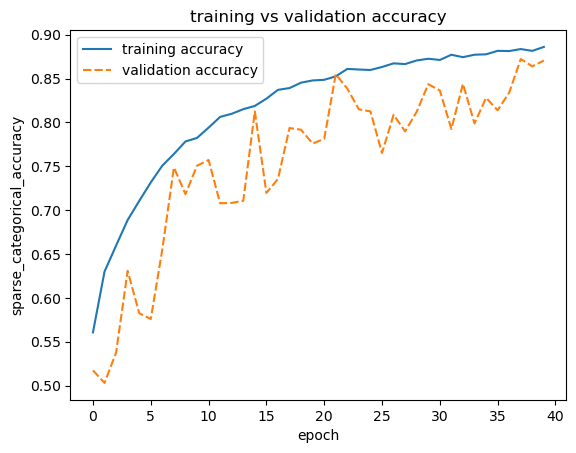

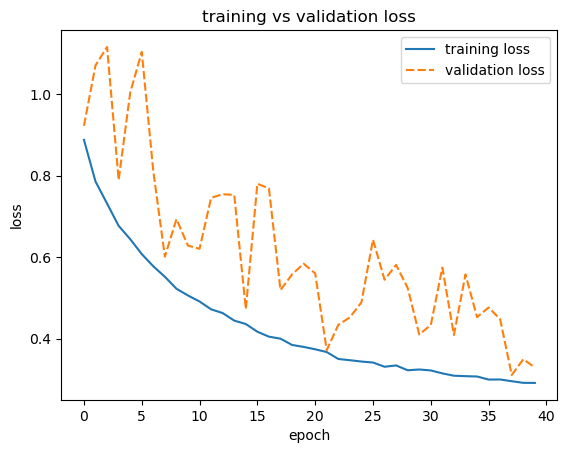

In [45]:
# This will succeed if the model was trained on Colab or an environment with GPU.
try:
    lab_utils.plot_train_eval(augmented_history)

# If it fails, load pre-generated history.
except NameError:

    # Load the history
    with open('./histories/augmented_history.pkl', "rb") as pickle_file:
        augmented_history = pickle.load(pickle_file)

    # Plot the train and dev accuracy and loss
    lab_utils.plot_train_eval(augmented_history)

Now, the validation accuracy follows the training accuracy more closely. This finding indicates that **the model is no longer overfitting**, which is quite a remarkable result achieved by just augmenting the existing images.

Another point worth mentioning is that this model achieves a slightly lower validation accuracy compared to the model without data augmentation. The model needs more epochs to train because it's dealing with a lot more variations in the dataset (due to the augmentations).


## Wrapping it up

**Congratulations on finishing this ungraded lab!**

It is quite amazing to see how data alone can impact machine learning models. Hopefully, this lab helped you better understand the importance of data.

In particular, you figured out ways to diagnose the effects of class imbalance and looked at specific metrics to spot this problem. Adding more data is a simple way to overcome class imbalance. However, this solution is not always feasible in a real life scenario.

In the final section, you applied multiple geometric transformations to the images in the training dataset to generate additional data. The goal was to use data augmentation to reduce overfitting. Changing the network architecture is also an alternative method to address this problem. In practice, it is a good idea to implement both techniques for better results.


**Keep it up!**